**Tabla de contenido**

- [Text Classification](#Text-Classification)
    - [The Dataset](#The-Dataset)
        - [A First Look at Hugging Face Datasets](#A-First-Look-at-Hugging-Face-Datasets)
        - [From Datasets to DataFrames](#From-Datasets-to-DataFrames)
        - [Looking at the Class Distribution](#Looking-at-the-Class-Distribution)
        - [How Long Are Our Tweets?](#How-Long-Are-Our-Tweets?)
    - [From Text to Tokens](#From-Text-to-Tokens)
        - [Character Tokenization](#Character-Tokenization)
        - [Word Tokenization](#Word-Tokenization)
        - [Subword Tokenization](#Subword-Tokenization)
        - [Tokenizing the Whole Dataset](#Tokenizing-the-Whole-Dataset)
    - [Training a Text Classifier](#Training-a-Text-Classifier)
        - [Transformers as Feature Extractors](#Transformers-as-Feature-Extractors)
            - [Using pretrained models](#Using-pretrained-models)

# Text Classification

`La clasificación de texto es una de las tareas más comunes en el procesamiento del lenguaje natural (NLP)`; se puede utilizar para una amplia gama de aplicaciones, como `clasificar comentarios` de clientes en categorías o dirigir tickets de soporte según su idioma. ¡Es probable que el filtro de spam de tu programa de correo electrónico esté utilizando clasificación de texto para proteger tu bandeja de entrada de una avalancha de correo no deseado!

Otro tipo común de `clasificación de textos es el análisis de sentimientos`, que (como vimos en el Capítulo 1) tiene como objetivo identificar la polaridad de un texto dado.

Ahora imagina que eres un científico de datos que necesita construir un sistema que pueda identificar automáticamente estados emocionales como "ira" o "alegría" que las personas expresan sobre el producto de tu empresa en Twitter. En este capítulo, abordaremos esta tarea utilizando una variante de BERT llamada `DistilBERT`.

La principal ventaja de este modelo es que `logra un rendimiento comparable al de BERT`, a la vez que es significativamente más pequeño y eficiente. Esto nos permite entrenar un clasificador en unos pocos minutos, y si deseas entrenar un modelo BERT más grande, simplemente puedes cambiar el `checkpoint` del modelo preentrenado. Un `checkpoint` corresponde al `conjunto de pesos que se cargan en una arquitectura de transformador dada`.

## The Dataset

Para construir nuestro detector de emociones utilizaremos un gran conjunto de datos de un artículo que exploró cómo se representan las emociones en los mensajes de Twitter en inglés. A diferencia de la mayoría de los conjuntos de datos de análisis de sentimientos que solo involucran polaridades “positivas” y “negativas”, `este conjunto de datos contiene seis emociones básicas: ira, asco, miedo, alegría, tristeza y sorpresa`.

### A First Look at Hugging Face Datasets

Usaremos Datasets para descargar los datos del Hugging Face Hub. Podemos usar la función list_datasets() para ver qué datasets están disponibles en el Hub:

In [1]:
#pip install huggingface-hub
from huggingface_hub import list_datasets

try:
    # Limitar a los primeros 100 datasets 
    datasets = list(list_datasets(limit=10))
    
    total = len(datasets)
    first_5 = [ds.id for ds in datasets[:5]]
    
    print(f"There are {total} datasets currently available on the Hub")
    print(f"The first 10 are: {first_5}")

except Exception as e:
    print(f"An error occurred: {str(e)}")


There are 10 datasets currently available on the Hub
The first 10 are: ['institutional/institutional-books-1.0', 'nvidia/Nemotron-Personas', 'fka/awesome-chatgpt-prompts', 'open-thoughts/OpenThoughts3-1.2M', 'openbmb/Ultra-FineWeb']


Vemos que a `cada conjunto de datos se le da un nombre`, así que carguemos el conjunto de datos de `emociones` con la función load_dataset():

In [2]:
from datasets import load_dataset
emotions = load_dataset("emotion")
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

vemos que `es similar a un diccionario de Python, donde cada clave corresponde a una división diferente`. Y podemos usar la sintaxis habitual de diccionario para acceder a una división individual:

In [3]:
train_ds = emotions["train"]
print(train_ds.column_names) # nombre de las columnas
print(train_ds.features) # imprime las clases que hay 
print(train_ds[:5]) # imprime los 5 primeros registros, con sus respectivas clases (label)

['text', 'label']
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}
{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


Tenga en cuenta que en este caso, `los valores del diccionario son ahora listas en lugar de elementos individuales`. También podemos obtener la columna completa por nombre:

In [4]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


### From Datasets to DataFrames

Aunque Datasets proporciona mucha funcionalidad de bajo nivel para segmentar y manipular nuestros datos, a menudo es conveniente convertir un objeto Dataset en un DataFrame de Pandas para que podamos acceder a APIs de alto nivel para la visualización de datos. Para habilitar la conversión, sets proporciona un método set_format() que nos permite cambiar el formato de salida del Dataset. Tenga en cuenta que esto no cambia el formato de datos subyacente (que es una tabla Arrow), y puede cambiar a otro formato más adelante si es necesario:

In [5]:
import pandas as pd
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


Como puedes ver, `los encabezados de las columnas se han conservado` y las primeras filas coinciden con nuestras vistas anteriores de los datos. `Sin embargo, las etiquetas se representan como enteros`, así que usemos el `método int2str()` de la característica de etiqueta `para crear una nueva columna en nuestro DataFrame con los nombres de etiqueta correspondientes`:

In [6]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)
df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


Antes de sumergirnos en la construcción de un clasificador, echemos un vistazo más de cerca al conjunto de datos. `Como señala Andrej Karpathy` en su famoso blog `“Una receta para entrenar redes neuronales”`, convertirse en `“uno con los datos”` es un paso esencial para entrenar grandes modelos!

### Looking at the Class Distribution

`Siempre que estés trabajando en problemas de clasificación de texto`, es una buena idea `examinar la distribución de ejemplos en las clases`. Un conjunto de datos con una distribución de clases sesgada podría requerir un tratamiento diferente en términos de pérdida de entrenamiento y métricas de evaluación que uno balanceado.

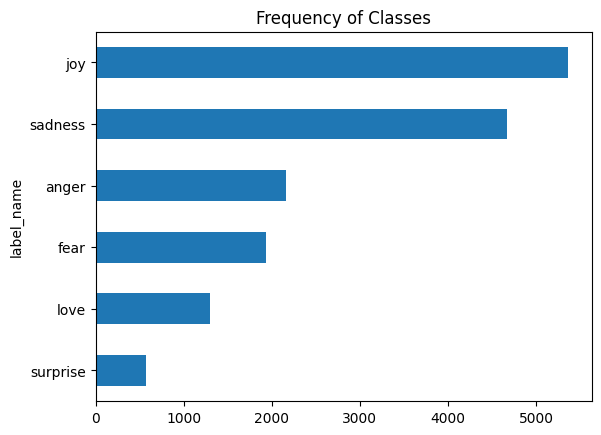

In [7]:
import matplotlib.pyplot as plt
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

En este caso, podemos ver que `el conjunto de datos está muy desbalanceado`; las clases de alegría y tristeza aparecen con frecuencia, mientras que amor y sorpresa son aproximadamente 5 a 10 veces más raras. Existen varias maneras de lidiar con datos desbalanceados, incluyendo:

- Sobremuestrear aleatoriamente la clase minoritaria.
- Submuestrear aleatoriamente la clase mayoritaria.
- Reunir más datos etiquetados de las clases subrepresentadas.

Si deseas aprender más sobre estas técnicas de muestreo, te recomendamos consultar la biblioteca `Imbalanced-learn`. `¡Solo asegúrate de no aplicar métodos de muestreo antes de crear tus divisiones de entrenamiento/prueba`, o tendrás mucha fuga entre ellas!

Ahora que hemos visto las clases, echemos un vistazo a los tweets en sí.

### How Long Are Our Tweets?

`Los modelos de transformadores tienen una longitud máxima de secuencia de entrada` que se conoce como el tamaño máximo del contexto `(maximum context size)`. Para las aplicaciones que utilizan DistilBERT, el tamaño máximo del contexto es de 512 tokens, lo que equivale a unos pocos párrafos de texto. Como veremos en la siguiente sección, un token es una pieza atómica de texto; por ahora, trataremos un token como una sola palabra. `Podemos obtener una estimación aproximada de las longitudes de los tuits por emoción observando la distribución de palabras por tuit`:

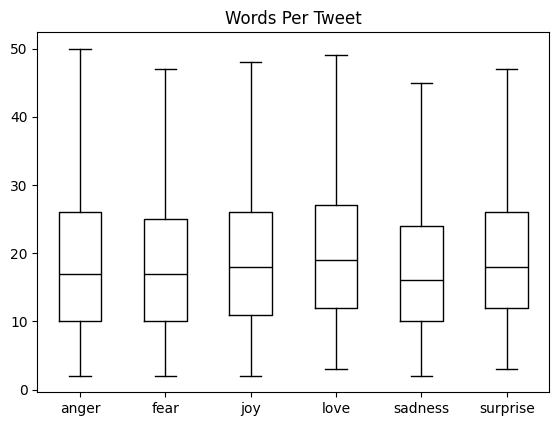

In [8]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False,
showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

A partir del gráfico, vemos que `para cada emoción, la mayoría de los tweets tienen alrededor de 15 palabras de longitud` y `los tweets más largos están muy por debajo del tamaño máximo de contexto de DistilBERT`. Los textos que son más largos que el tamaño de contexto de un modelo necesitan ser truncados, lo que puede llevar a una pérdida de rendimiento si el texto truncado contiene información crucial; en este caso, parece que eso no será un problema.

`¡Ahora descubramos cómo podemos convertir estos textos en bruto en un formato adecuado para Transformers!` Mientras estamos en eso, `también reiniciemos el formato de salida de nuestro conjunto de datos ya que no necesitamos más el formato de DataFrame`:

In [9]:
emotions.reset_format()

## From Text to Tokens

`Los modelos de transformadores como DistilBERT no pueden recibir cadenas de texto sin procesar como entrada; en su lugar, asumen que el texto ha sido tokenizado y codificado como vectores numéricos`. `La tokenización es el paso de descomponer una cadena en las unidades  utilizadas en el modelo`. Hay varias estrategias de tokenización que se pueden adoptar, y la división óptima de las palabras en subunidades generalmente se aprende del corpus. Antes de mirar el tokenizador utilizado para DistilBERT, consideremos dos casos extremos: `la tokenización a nivel de caracteres` y `la tokenización a nivel de palabras`.


### Character Tokenization

In [10]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


Este es un buen comienzo, pero aún no hemos terminado. `Nuestro modelo espera que cada carácter se convierta en un entero`, un proceso que a veces se llama numerización. Una forma sencilla de hacer esto es codificando cada token único (que son caracteres en este caso) con un entero único:

In [11]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


Esto nos da un mapeo de cada carácter en nuestro vocabulario a un entero único. Ahora podemos usar token2idx para transformar el texto tokenizado en una lista de enteros:

In [12]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


Cada token ahora se ha mapeado a un identificador numérico único (de ahí el nombre input_ids). El último paso es convertir input_ids en un tensor 2D de vectores one-hot. Los vectores one-hot se utilizan con frecuencia en el aprendizaje automático para codificar datos categóricos, que pueden ser ordinales o nominales. Por ejemplo, supongamos que queremos codificar los nombres de los personajes de la serie de televisión Transformers. Una forma de hacer esto sería mapear cada nombre a una ID única, de la siguiente manera:

In [13]:
categorical_df = pd.DataFrame(
{"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


El problema con este enfoque es que crea un orden ficticio entre los nombres, y las redes neuronales son muy buenas para aprender este tipo de relaciones. Así que, en lugar de eso, podemos crear una nueva columna para cada categoría y asignar un 1 donde la categoría sea verdadera y un 0 en caso contrario. En Pandas, esto se puede implementar con la función get_dummies() de la siguiente manera:

In [14]:
pd.get_dummies(categorical_df["Name"],dtype=int)

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


Podemos crear las codificaciones one-hot en PyTorch convirtiendo `input_ids` en un tensor y aplicando la función one_hot() de la siguiente manera:

In [15]:
import torch
import torch.nn.functional as F
input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

`Para cada uno de los 38 tokens de entrada, ahora tenemos un vector one-hot con 20 dimensiones, ya que nuestro vocabulario consiste en 20 caracteres únicos.`

`Nota`: `Es importante siempre establecer num_classes en la función one_hot()` porque de lo contrario los vectores one-hot pueden terminar siendo más cortos que la longitud del vocabulario (y necesitarán ser rellenados con ceros manualmente). En TensorFlow, la función equivalente es tf.one_hot(), donde el argumento depth cumple el papel de num_classes.

Al examinar el primer vector, podemos verificar que un 1 aparece en la ubicación indicada por input_ids[0]:


In [16]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


A partir de nuestro simple ejemplo, podemos ver que la tokenización a nivel de caracteres ignora cualquier estructura en el texto y trata toda la cadena como un flujo de caracteres. `Aunque esto ayuda a lidiar con errores ortográficos y palabras raras, la principal desventaja es que las estructuras lingüísticas, como las palabras, necesitan ser aprendidas a partir de los datos. Esto requiere un uso significativo de cómputo, memoria y datos`. Por esta razón, `la tokenización de caracteres rara vez se utiliza en la práctica`. En cambio, se preserva alguna estructura del texto durante el proceso de tokenización. La tokenización de palabras es un enfoque simple para lograr esto, así que echemos un vistazo a cómo funciona.

### Word Tokenization

`En lugar de dividir el texto en caracteres, podemos dividirlo en palabras y mapear cada palabra a un número entero`. `Utilizar palabras desde el principio permite al modelo omitir el paso de aprender palabras a partir de caracteres`, y así reduce la complejidad del proceso de entrenamiento.

`Una clase simple de tokenizadores de palabras utiliza el espacio en blanco para tokenizar el texto`. Podemos hacer esto aplicando la función split() de Python directamente en el texto bruto (tal como lo hicimos para medir las longitudes de los tweets):

In [17]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


Desde aquí podemos seguir los mismos pasos que tomamos para el tokenizador de caracteres para mapear cada palabra a un ID. Sin embargo, ya `podemos ver un posible problema con este esquema de tokenización`: `la puntuación no se tiene en cuenta`, por lo que NLP. se trata como un único token. `Dado que las palabras pueden incluir declinaciones, conjugaciones o errores ortográficos`, `¡el tamaño del vocabulario puede crecer fácilmente hasta millones!`

`Nota`: `Algunos tokenizadores de palabras tienen reglas adicionales para la puntuación`. También se puede aplicar el `stemming` o la `lemmatization`, que normaliza las palabras a su raíz (por ejemplo, "grande", "mayor" y "el más grande" se convierten en "grande"), a costa de perder algo de información en el texto.

Tener un vocabulario grande es un problema porque requiere que las redes neuronales tengan un número enorme de parámetros. Naturalmente, queremos evitar ser tan derrochadores con los parámetros de nuestro modelo, ya que los modelos son costosos de entrenar y los modelos más grandes son más difíciles de mantener. 

`Un enfoque común es limitar el vocabulario y descartar palabras raras considerando, por ejemplo, las 100,000 palabras más comunes en el corpus`. Las palabras que no forman parte del vocabulario se clasifican como "desconocidas" y se asignan a un token compartido UNK. Esto significa que perdemos información potencialmente importante en el proceso de tokenización de palabras, ya que el modelo no tiene información sobre las palabras asociadas con UNK.

¿No sería genial si hubiera un compromiso entre la tokenización de caracteres y la tokenización de palabras que preservara toda la información de entrada y parte de la estructura de entrada? Sí lo hay: `la tokenización de subpalabras.`


### Subword Tokenization

`La idea básica detrás de la tokenización de subpalabras es combinar los mejores aspectos de la tokenización por caracteres y palabras.` Por un lado, queremos `dividir palabras raras en unidades más pequeñas` para permitir que `el modelo lidie con palabras complejas y errores ortográficos`. Por otro lado, queremos mantener palabras frecuentes como entidades únicas para que podamos mantener la longitud de nuestras entradas a un tamaño manejable. `La principal característica distintiva de la tokenización de subpalabras` (así como de la tokenización por palabras) `es que se aprende del corpus de preentrenamiento utilizando una mezcla de reglas y algoritmos estadísticos`.

`Hay varios algoritmos de tokenización de subpalabras que se utilizan comúnmente en NLP`, pero comencemos con `WordPiece`, que es utilizado por los tokenizadores de BERT y DistilBERT. La forma más fácil de entender cómo funciona WordPiece es verlo en acción. Transformers proporciona una conveniente clase AutoTokenizer que te permite cargar rápidamente el tokenizador asociado con un modelo preentrenado: solo llamamos a su método from_pretrained(), proporcionando la ID de un modelo en el Hub o una ruta de archivo local. Comencemos cargando el tokenizador para DistilBERT:

In [18]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

La clase `AutoTokenizer` pertenece a un conjunto más amplio de clases "auto", `cuyo trabajo es recuperar automáticamente la configuración del modelo`, `los pesos preentrenados o el vocabulario a partir del nombre del punto de control`. Esto te permite cambiar rápidamente entre modelos, pero si deseas cargar la clase específica manualmente, también puedes hacerlo. Por ejemplo, podríamos haber cargado el tokenizador DistilBERT de la siguiente manera:

In [19]:
from transformers import DistilBertTokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

Examinemos cómo funciona este tokenizador alimentándolo con nuestro simple ejemplo de “Tokenizing text is a core task of NLP.”

In [20]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Al igual que con la tokenización de caracteres, podemos ver que las palabras han sido mapeadas a enteros únicos en el campo input_ids. Discutiremos el papel del campo attention_mask en la siguiente sección. `Ahora que tenemos los input_ids, podemos convertirlos de nuevo en tokens usando el método convert_ids_to_tokens() del tokenizador:`

In [21]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


`Podemos observar tres cosas aquí`: 
- Primero, se han agregado algunos `tokens especiales` `[CLS]` y `[SEP]` al `inicio` y al `final` de la secuencia. Estos tokens difieren de un modelo a otro, pero `su función principal es indicar el inicio y el final de una secuencia`.

- En segundo lugar, `los tokens han sido convertidos a minúsculas`, lo cual es una característica de este punto de control en particular. Finalmente, podemos ver que `"tokenizing"` y `"NLP"` se han dividido en dos tokens, lo que tiene sentido dado que no son palabras comunes.

`El prefijo ##` en ##izando y ##p `significa que la cadena anterior no es un espacio en blanco`; cualquier token con este prefijo debe fusionarse con el token anterior cuando conviertas los tokens de nuevo a una cadena. La clase AutoTokenizer tiene un método convert_tokens_to_string() para hacer exactamente eso, así que apliquémoslo a nuestros tokens:

In [22]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


La clase AutoTokenizer también tiene varios atributos que proporcionan información sobre el tokenizador. Por ejemplo, podemos inspeccionar el tamaño del vocabulario:

In [23]:
tokenizer.vocab_size

30522

y el tamaño máximo de contexto del modelo correspondiente:

In [24]:
tokenizer.model_max_length

512

Otro atributo interesante que hay que conocer son los nombres de los campos que el modelo espera en su paso hacia adelante:

In [25]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

Ahora que tenemos una comprensión básica del proceso de tokenización para una sola cadena, `¡veamos cómo podemos tokenizar todo el conjunto de datos!`

`Nota`: Al usar modelos preentrenados, es muy importante asegurarse de usar el mismo tokenizador con el que se entrenó el modelo. Desde la perspectiva del modelo, cambiar el tokenizador es como barajar el vocabulario. Si todos a tu alrededor comenzaran a intercambiar palabras aleatorias como “casa” por “gato,” también tendrías dificultades para entender lo que está sucediendo.


### Tokenizing the Whole Dataset

`Para tokenizar todo el corpus, usaremos el método map()` de nuestro objeto DatasetDict. Encontraremos este método muchas veces a lo largo de este libro, ya que proporciona una forma conveniente de aplicar una función de procesamiento a cada elemento en un conjunto de datos. Como pronto veremos, `el método map() también se puede usar para crear nuevas filas y columnas`.

Para empezar, lo primero que necesitamos es una función de procesamiento para tokenizar nuestros ejemplos.

Esta función aplica el tokenizador a un lote de ejemplos; `padding=True` rellenará los ejemplos con ceros hasta el tamaño más largo en un lote, y `truncation=True` truncará los ejemplos hasta el tamaño máximo de contexto del modelo. Para ver tokenize() en acción, pasemos un lote de dos ejemplos del conjunto de entrenamiento:

In [27]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


Aquí podemos ver el resultado del padding: el primer elemento de input_ids es más corto que el segundo, por lo que se han añadido ceros a ese elemento para que tengan la misma longitud. Estos ceros tienen un token [PAD] correspondiente en el vocabulario, y el conjunto de tokens especiales también incluye los tokens [CLS] y [SEP] que encontramos anteriormente.

`También ten en cuenta que, además de devolver los tweets codificados como input_ids`, `el tokenizador devuelve una lista de arreglos de attention_mask`. Esto se debe a que no queremos que el modelo se confunda por los tokens de relleno adicionales: la máscara de atención permite al modelo ignorar las partes rellenadas de la entrada. La siguiente figura proporciona una explicación visual de cómo se rellenan los input IDs y las máscaras de atención.
![Texto alternativo](images/token.png)

*Para cada lote, las secuencias de entrada se rellenan hasta la longitud máxima de secuencia en el lote; la máscara de atención se utiliza en el modelo para ignorar las áreas rellenadas de los tensores de entrada.*

Una vez que hayamos definido una función de procesamiento, podemos aplicarla a todas las divisiones del corpus en una sola línea de código:

In [28]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Por defecto, el `método map()` opera individualmente en cada ejemplo del corpus, por lo que establecer `batched=True` `codificará los tweets en lotes`. Dado que hemos establecido `batch_size=None`, `nuestra función tokenize() se aplicará a todo el conjunto de datos como un solo lote`. `Esto asegura que los tensores de entrada y las máscaras de atención tengan la misma forma a nivel global`, y podemos ver que esta operación ha añadido nuevas columnas input_ids y attention_mask al conjunto de datos:

In [29]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


## Training a Text Classifier

Como se discutió en el Capítulo 1, `modelos como DistilBERT están preentrenados para predecir palabras enmascaradas en una secuencia de texto`. `Sin embargo, no podemos usar estos modelos de lenguaje directamente para la clasificación de texto`; `necesitamos modificarlos ligeramente`. Para comprender qué modificaciones son necesarias, echemos un vistazo a la arquitectura de un modelo basado en codificadores como DistilBERT, que se representa en la siguiente figura.
![aquitectura modelo basado en codificadores](images/arquitecturamodelo.png)
*La arquitectura utilizada para la clasificación de secuencias con un transformador basado en un codificador; consiste en el cuerpo preentrenado del modelo combinado con una cabeza de clasificación personalizada.*

Primero, el texto se tokeniza y se representa como vectores one-hot llamados codificaciones de tokens. El tamaño del vocabulario del tokenizador determina la dimensión de las codificaciones de tokens, y generalmente consiste en 20k a 200k tokens únicos. A continuación, estas codificaciones de tokens se convierten en token embeddings, que son vectores que viven en un espacio de menor dimensión. Luego, los token embeddings se pasan a través de las capas del bloque del codificador para generar un `hidden state` para cada token de entrada. `Para el objetivo de preentrenamiento de modelado de lenguaje`, cada `hidden state` se alimenta a una capa que predicew los `masked input tokens`. Para la tarea de clasificación, reemplazamos la capa de modelado de lenguaje por una capa de clasificación.

`Nota`: En la práctica, PyTorch omite el paso de crear vectores one-hot para las codificaciones de tokens, porque multiplicar una matriz con un vector one-hot es lo mismo que seleccionar una columna de la matriz. Esto se puede hacer directamente obteniendo la columna con el ID del token de la matriz. 

`Tenemos dos opciones para entrenar un modelo así en nuestro conjunto de datos de Twitter:`
- **Feature extraction**: Utilizamos los estados ocultos (hidden states) como características y simplemente entrenamos un clasificador sobre ellos, sin modificar el modelo preentrenado.
- **Fine-tuning**: Entrenamos todo el modelo de extremo a extremo, lo que también actualiza los parámetros del modelo preentrenado.

`En las siguientes secciones exploramos ambas opciones para DistilBERT y examinamos sus compensaciones.`

### Transformers as Feature Extractors

`Usar un transformador como extractor de características es bastante simple`. Como se muestra en la siguiente Figura, congelamos los pesos del cuerpo durante el entrenamiento y usamos los estados ocultos como características para el clasificador. `La ventaja de este enfoque es que podemos entrenar rápidamente un modelo pequeño o superficial`. Tal modelo podría ser una capa de clasificación neuronal o un método que no dependa de gradientes, como un bosque aleatorio. `Este método es especialmente conveniente si las GPU no están disponibles,` ya que los estados ocultos solo necesitan ser precomputados una vez.

![features stractor](images/featurestractor.png)
*En el enfoque basado en características, el modelo DistilBERT está congelado y solo proporciona características para un clasificador.*

#### Using pretrained models